# PID Control with Bumpless Transfer

## Switching from Manual to Automatic Control

The following cells simulate a common situation where a system is manually controlled to a desired steady state, then a controller turned on to maintain that state without further operator intervention. Examples include a pilot switching to autopilot of an aircraft at cruising altititude, or a car driver turning on cruise-control once at a desired highway driving speed.

For this simulation we use PID control with setpoint weighting.

In [1]:
def PID(Kp, Ki, Kd, MV_bar=0, beta=1, gamma=0):
    # initialize stored data
    eD_prev = 0
    t_prev = -100
    I = 0
    
    # initial control
    MV = MV_bar
    
    while True:
        # yield MV, wait for new t, SP, PV
        t, SP, PV = yield MV
        
        # PID calculations
        P = Kp*(beta*SP - PV)
        I = I + Ki*(SP - PV)*(t - t_prev)
        eD = gamma*SP - PV
        D = Kd*(eD - eD_prev)/(t - t_prev)
        MV = MV_bar + P + I + D
        
        # update stored data for next iteration
        eD_prev = eD
        t_prev = t

The desired setpoint is 50°C which is acheived with a power setting of approximately 50%.  We'll start out at the power setting for a period of 400 seconds, then turn on the controller.

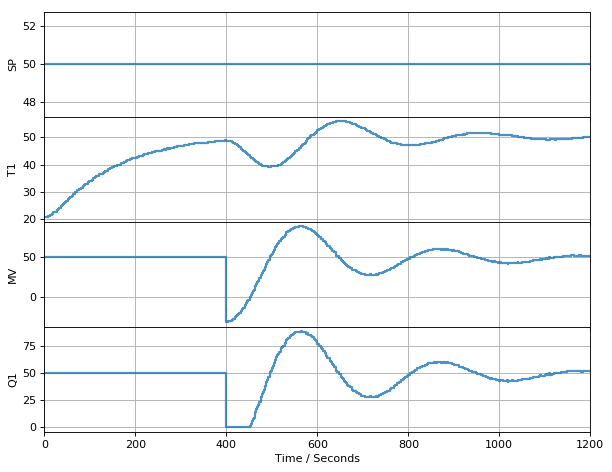

TCLab Model disconnected successfully.


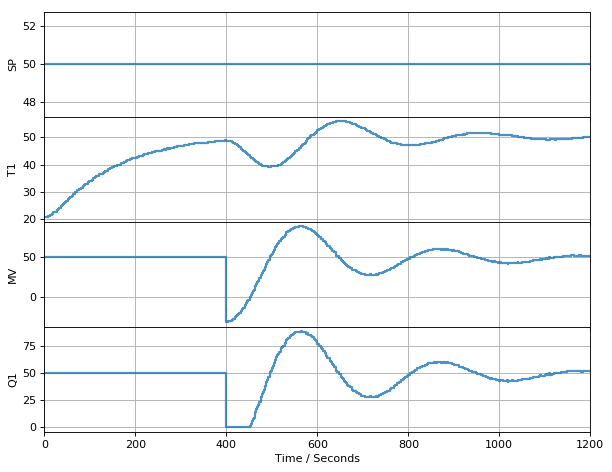

In [2]:
%matplotlib inline
from tclab import clock, setup, Historian, Plotter

TCLab = setup(connected=False, speedup=10)

controller = PID(2, 0.1, 2, beta=0)   # create pid control
controller.send(None)                 # initialize

tfinal = 1200
SP = 50

with TCLab() as lab:
    h = Historian([('SP', lambda: SP), ('T1', lambda: lab.T1), ('MV', lambda: MV), ('Q1', lab.Q1)])
    p = Plotter(h, tfinal)
    for t in clock(tfinal, 2):
        PV = lab.T1                            # get measurement
        if t < 400:                            # choice between manual and auto control
            MV = 50
        else:
            MV = controller.send([t, SP, PV])
        lab.U1 = MV                            # apply 
        p.update(t)                            # update information display

## Bumpless Transfer

The previous simulation would be a genuine problem for most process operators. You have a controller that can do the job but there is no acceptable way to turn it on. Can you imagine if this happen each time a pilot turned on an autopilot, or a driver turn on cruise control?

What we need is a property called **bumpless transfer**.  Bumpless transfer is a control feature that minimizes any disturbances encountered on the transition from manual to automatic operation.

There are actually three elements bumpless transfer.

1. Get the controller output to track the manipulated variable.
2. Setpoint tracks the process variable during manual control.
3. Start at or near a steady state.

### Tracking the Manipulated Variable

As we've seen in previous simulations, the output of the controller might not match the actual value applied to the process.  In the simulations this was due to controller output exceeding the physical limits of the manipulated variable. In the case of bumpless transfer, the cause is due to the manual adjustment of the manipulated variable. 

To address this issue, we add a new input to the controller called **tracking**. The controller will then attempt to maintain the output value of the manipulated variable equal to the tracking input. This will turn out to provide a number of useful properties.

In [3]:
def PID(Kp, Ki, Kd, MV_bar=0, beta=1, gamma=0):
    # initialize stored data
    eD_prev = 0
    t_prev = -100
    P = 0
    I = 0
    D = 0
    
    # initial control
    MV = MV_bar
    
    while True:
        # yield MV, wait for new t, SP, PV, TR
        t, PV, SP, TR = yield MV
        
        # adjust I term so output matches tracking input
        I = TR - MV_bar - P - D
        
        # PID calculations
        P = Kp*(beta*SP - PV)
        I = I + Ki*(SP - PV)*(t - t_prev)
        eD = gamma*SP - PV
        D = Kd*(eD - eD_prev)/(t - t_prev)
        MV = MV_bar + P + I + D
        
        # update stored data for next iteration
        eD_prev = eD
        t_prev = t

The implementation code also changes. In effect, the controller is always on, even if the input to process is under manual control. In `manual` mode, the controller is monitoring and tracking the manipulated variable, and always ready to take over when switched to automatic control.

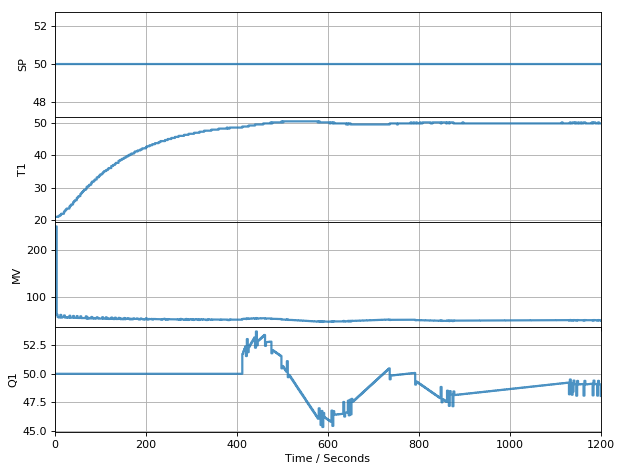

TCLab Model disconnected successfully.


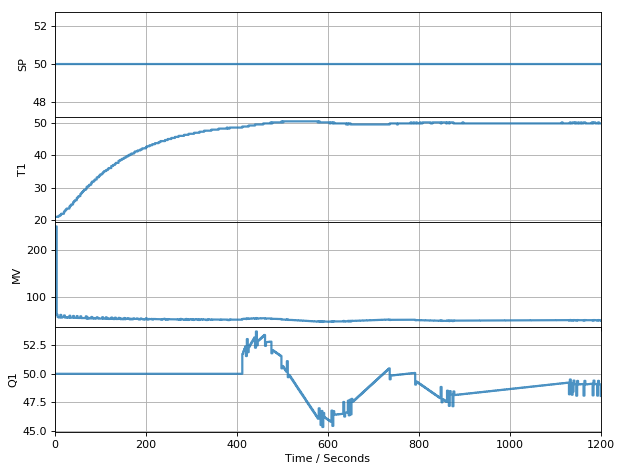

In [4]:
%matplotlib inline
from tclab import clock, setup, Historian, Plotter

TCLab = setup(connected=False, speedup=10)

controller = PID(2, 0.1, 2, beta=0)   # create pid control
controller.send(None)                 # initialize

tfinal = 1200
SP = 50

with TCLab() as lab:
    h = Historian([('SP', lambda: SP), ('T1', lambda: lab.T1), ('MV', lambda: MV), ('Q1', lab.Q1)])
    p = Plotter(h, tfinal)
    for t in clock(tfinal, 2):
        PV = lab.T1                            # get measurement
        MV = controller.send([t, PV, SP, lab.Q1()])
        if t < 400:
            lab.U1 = 50
        else:
            lab.U1 = MV                        # compute control action
        p.update(t)                            # update information display

### Setpoint Tracking

A second component of bumpless transfer is to have the setpoint track the process variable.  This is generally what we do in automotive cruise control when we push the `set` button.

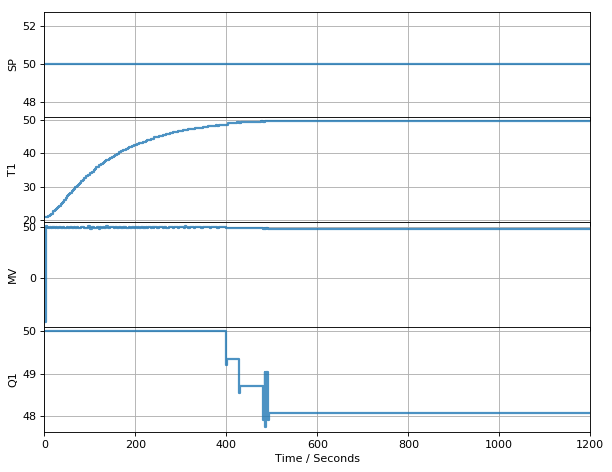

TCLab Model disconnected successfully.


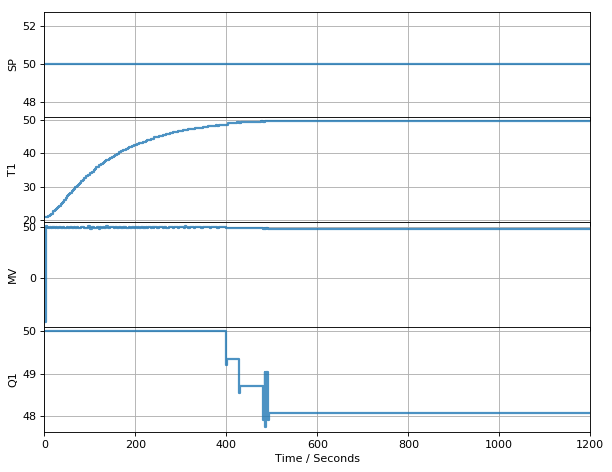

In [5]:
%matplotlib inline
from tclab import clock, setup, Historian, Plotter

TCLab = setup(connected=False, speedup=10)

controller = PID(2, 0.1, 2, beta=0)   # create pid control
controller.send(None)                 # initialize

tfinal = 1200
SP = 50

with TCLab() as lab:
    h = Historian([('SP', lambda: SP), ('T1', lambda: lab.T1), ('MV', lambda: MV), ('Q1', lab.Q1)])
    p = Plotter(h, tfinal)
    for t in clock(tfinal, 2):
        PV = lab.T1                            # get measurement
        MV = controller.send([t, PV, PV, lab.Q1()])
        if t < 400:
            lab.U1 = 50
        else:
            lab.U1 = MV                        # compute control action
        p.update(t)                            # update information display

### Steady State

The final condition to assure bumpless transfer is to at or very near to a steady state. To demonsrate, we will repeat the last simulation, except execute the manual to auto transition at $t$ = 600 seconds.

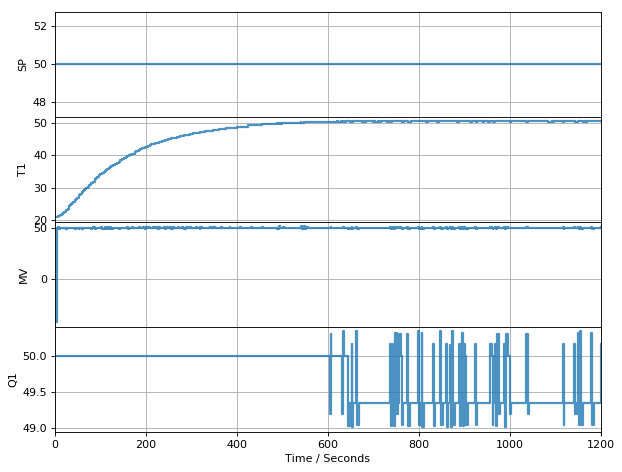

TCLab Model disconnected successfully.


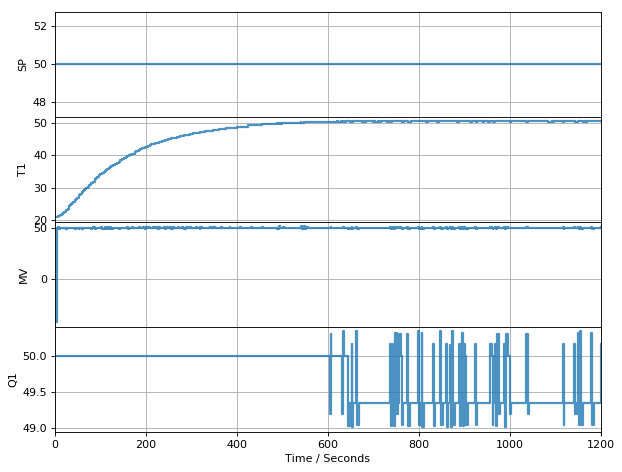

In [6]:
%matplotlib inline
from tclab import clock, setup, Historian, Plotter

TCLab = setup(connected=False, speedup=10)

controller = PID(2, 0.1, 2, beta=0)   # create pid control
controller.send(None)                 # initialize

tfinal = 1200
SP = 50

with TCLab() as lab:
    h = Historian([('SP', lambda: SP), ('T1', lambda: lab.T1), ('MV', lambda: MV), ('Q1', lab.Q1)])
    p = Plotter(h, tfinal)
    for t in clock(tfinal, 2):
        PV = lab.T1                            # get measurement
        MV = controller.send([t, PV, PV, lab.Q1()])
        if t < 600:
            lab.U1 = 50
        else:
            lab.U1 = MV                        # compute control action
        p.update(t)                            # update information display